##### Copyright 2019 Jacob Turpin and The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image segmentation

This project represents a derivative work from the following: 

* TensorFlow Examples -- Image Segementation (see buttons below)
* TensorFlow.js Examples -- BodyPix [(Source)](https://github.com/tensorflow/tfjs-models/tree/master/body-pix)

<h3>Tensorflow Examples -- Image Segmentation</h3>
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This project focuses on the task of image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?
Image classification, the more simplistic case, is the task where a neural network assigns a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

In [0]:
import os
import random

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from sklearn.model_selection import train_test_split

## Download the MS COCO Dataset

Based upon modified version of:

* https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-2-of-2-c0d1f593096a
* https://towardsdatascience.com/a-keras-pipeline-for-image-segmentation-part-1-6515a421157d

In [3]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2020-06-10 21:28:07--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.138.179
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.138.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  81.0MB/s    in 3.0s    

2020-06-10 21:28:10 (81.0 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [4]:
!unzip annotations_trainval2017.zip

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [0]:
from pycocotools.coco import COCO

In [0]:
dataDir='.'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [0]:
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/instances_{}.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [8]:
images, dataset_size, coco = filterDataset(dataDir, ['keyboard'], 'train2017')

loading annotations into memory...
Done (t=13.51s)
creating index...
index created!


In [9]:
images[:5]

[{'coco_url': 'http://images.cocodataset.org/train2017/000000272510.jpg',
  'date_captured': '2013-11-18 11:16:17',
  'file_name': '000000272510.jpg',
  'flickr_url': 'http://farm7.staticflickr.com/6005/5960463220_d602955015_z.jpg',
  'height': 439,
  'id': 272510,
  'license': 3,
  'width': 640},
 {'coco_url': 'http://images.cocodataset.org/train2017/000000071563.jpg',
  'date_captured': '2013-11-24 03:15:39',
  'file_name': '000000071563.jpg',
  'flickr_url': 'http://farm2.staticflickr.com/1330/4728191205_cfdc3549b9_z.jpg',
  'height': 480,
  'id': 71563,
  'license': 1,
  'width': 640},
 {'coco_url': 'http://images.cocodataset.org/train2017/000000496926.jpg',
  'date_captured': '2013-11-21 02:15:12',
  'file_name': '000000496926.jpg',
  'flickr_url': 'http://farm3.staticflickr.com/2645/4092844933_74aa6cf678_z.jpg',
  'height': 375,
  'id': 496926,
  'license': 5,
  'width': 500},
 {'coco_url': 'http://images.cocodataset.org/train2017/000000530047.jpg',
  'date_captured': '2013-11-24

## Create Data Generators

In [0]:
import skimage.io as io

def dataGeneratorCoco(images, classes, coco, input_image_size=(224,224), batch_size=4):
    
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = io.imread(images[i]['coco_url']) / 255.0
            train_img = cv2.resize(train_img, input_image_size)
            #print(train_img.shape)
            
            ### Create Mask ###
            train_mask = np.zeros(input_image_size)

            annIds = coco.getAnnIds(imgIds=images[i]['id'], catIds=catIds, iscrowd=None)
            anns = coco.loadAnns(annIds)
            img_mask = sum(coco.annToMask(x) for x in anns)
            new_mask = cv2.resize(img_mask, input_image_size)
        
            #Threshold because resizing may cause extraneous values
            new_mask[new_mask >= 0.5] = 1
            new_mask[new_mask < 0.5] = 0

            train_mask = np.maximum(new_mask, train_mask)
            train_mask = train_mask[..., np.newaxis]
            #print(mask.shape)
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [0]:
batch_size = 4
input_image_size = (224,224)
mask_type = 'binary'

example_gen = dataGeneratorCoco(images, ['keyboard'], coco, input_image_size, batch_size)

In [0]:
def visualizeGenerator(gen):
    img, mask = next(gen)

    #print(img.shape)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

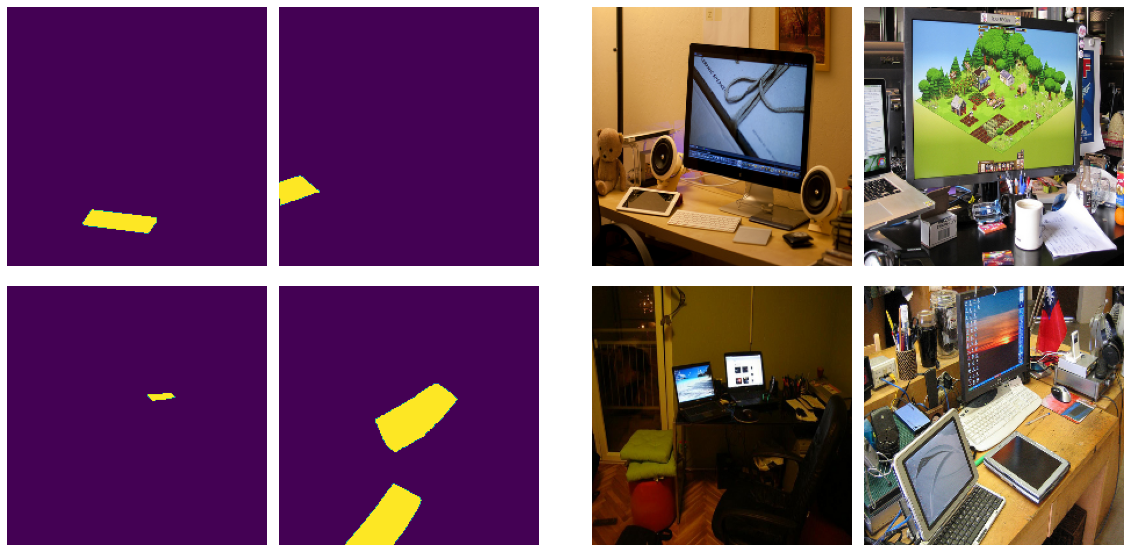

In [15]:
visualizeGenerator(example_gen)

In [0]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

In [0]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

aug_gen = augmentationsGenerator(example_gen, augGeneratorArgs)

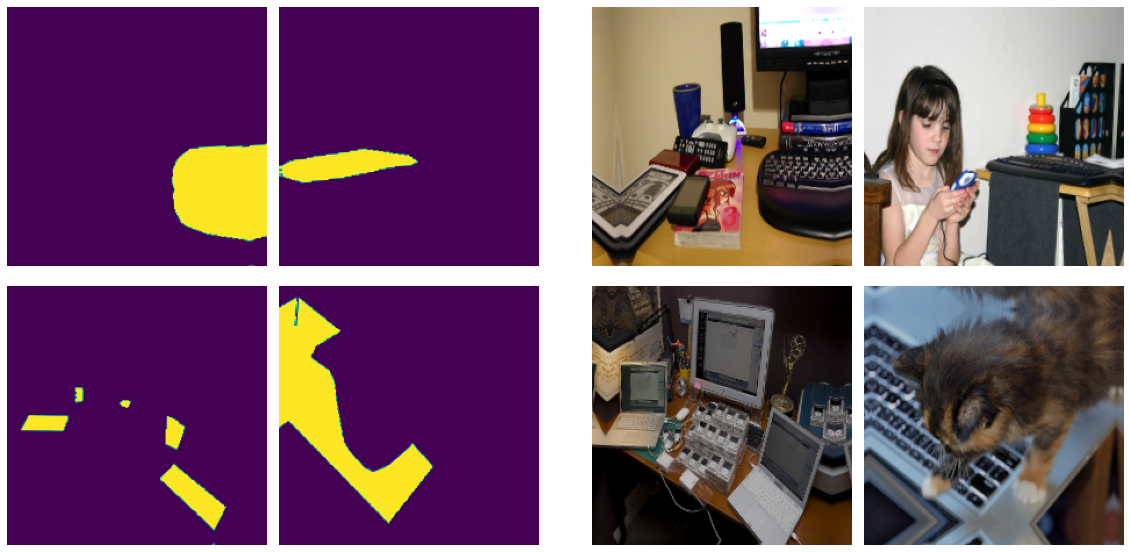

In [22]:
visualizeGenerator(aug_gen)

The dataset already contains the required splits of test and train and so let's continue to use the same split.

In [23]:
train_imageIds, val_imageIds = train_test_split(images, test_size=0.2)
print('Train Length: {}'.format(len(train_imageIds)))
print('Val Length: {}'.format(len(val_imageIds)))

Train Length: 1692
Val Length: 423


In [0]:
BATCH_SIZE = 16

TRAIN_LENGTH = len(train_imageIds)
TRAIN_STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_LENGTH = len(val_imageIds)
VAL_STEPS_PER_EPOCH = VAL_LENGTH // BATCH_SIZE

In [0]:
train_gen = augmentationsGenerator(
    dataGeneratorCoco(train_imageIds, ['keyboard'], coco, (128, 128), BATCH_SIZE),
    augGeneratorArgs
    )

val_gen = augmentationsGenerator(
    dataGeneratorCoco(val_imageIds, ['keyboard'], coco, (128, 128), BATCH_SIZE),
    augGeneratorArgs
    ) 


## Define the model
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

In [0]:
OUTPUT_CHANNELS = 1

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [27]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
#down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

#down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
for l in base_model.layers:
  l.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [0]:
def upsample(filters, size, input_shape, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False,
                                      input_shape=input_shape))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
up_stack = [
    upsample(512, 3, (4, 4, 320)),  # 4x4 -> 8x8
    upsample(256, 3, (8, 8, 1088)),  # 8x8 -> 16x16
    upsample(128, 3, (16, 16, 448)),  # 16x16 -> 32x32
    upsample(64, 3, (32, 32, 272)),   # 32x32 -> 64x64
]

In [0]:
#inputs = tf.keras.layers.Input(shape=[128, 128, 3])
#x = inputs

# Downsampling through the model
skips = layers
x = skips[-1]
skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
  x = up(x)
  concat = tf.keras.layers.Concatenate()
  x = concat([x, skip])

# This is the last layer of the model
last = tf.keras.layers.Conv2DTranspose(
    OUTPUT_CHANNELS, 3, strides=2,
    padding='same', activation='sigmoid')  #64x64 -> 128x128

x = last(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [0]:
#model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Have a quick look at the resulting model architecture:

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

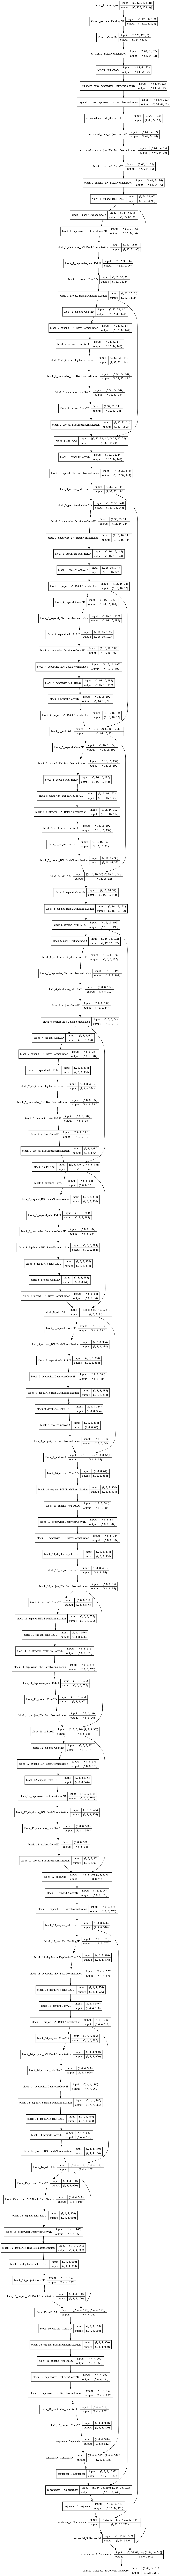

In [34]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [0]:
# TODO: insert callbacks

In [36]:
EPOCHS = 1

model_history = model.fit(
    train_gen, 
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS_PER_EPOCH,
    validation_data=val_gen,
    #callbacks=[DisplayCallback()])
)

105/105 [==============================] - 364s 3s/step - loss: 0.2487 - accuracy: 0.9067 - val_loss: 0.2026 - val_accuracy: 0.9284


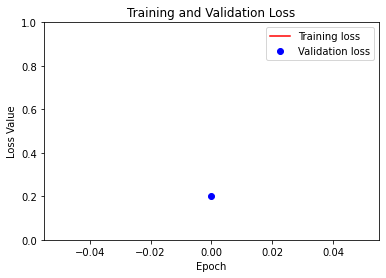

In [37]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

In [0]:
# TODO

## Model Conversion

In [0]:
model.save('model.h5')

In [0]:
!pip install tensorflowjs --no-deps

     |████████████████████████████████| 61kB 5.2MB/s 


In [0]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'tfjs')

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [0]:
!zip -r tfjs.zip ./tfjs/

updating: tfjs/ (stored 0%)
updating: tfjs/model.json (deflated 95%)
updating: tfjs/group1-shard3of7.bin (deflated 7%)
updating: tfjs/group1-shard7of7.bin (deflated 7%)
updating: tfjs/group1-shard1of7.bin (deflated 7%)
updating: tfjs/group1-shard6of7.bin (deflated 7%)
updating: tfjs/group1-shard4of7.bin (deflated 7%)
updating: tfjs/group1-shard5of7.bin (deflated 7%)
updating: tfjs/group1-shard2of7.bin (deflated 7%)


In [0]:
import os
from google.colab import files

for f in os.listdir('tfjs'):

  files.download('tfjs/' + f)